# Feature Selection con Scikit-Learn

Este Notebook es una guía completa sobre la **Selección de Características**, un paso crítico para construir modelos de Machine Learning eficientes e interpretables.

## Objetivos de la sesión:
1.  **Reducir la dimensionalidad:** Eliminar el ruido y evitar la "maldición de la dimensionalidad".
2.  **Mejorar el rendimiento:** Prevenir el overfitting y acelerar el entrenamiento.
3.  **Dominar Scikit-Learn:** Implementar métodos Filter, Wrapper y Embedded.

---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de Scikit-Learn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (VarianceThreshold, SelectKBest,
                                      f_classif, RFE, SelectFromModel)
from sklearn.metrics import accuracy_score

# Configuración visual
%matplotlib inline
sns.set_theme(style="whitegrid")

# Carga de datos
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split inicial (Fundamental: La selección se entrena solo con el Train Set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Dimensiones originales: {X_train.shape}")
X.head()

Dimensiones originales: (398, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 1. Métodos de Filtro (Filter Methods)
Son independientes del modelo de ML. Evalúan las características basándose en métricas estadísticas.

### A. Variance Threshold
Elimina variables que no cambian lo suficiente. Si una variable es constante (o casi constante), no tiene poder predictivo.

### B. SelectKBest (ANOVA F-Test)
Mide la dependencia lineal entre la variable y el objetivo.
**F-score:** $F = \frac{\text{Varianza entre grupos}}{\text{Varianza dentro de los grupos}}$

Variables tras Varianza: 14
Variables tras ANOVA: 10


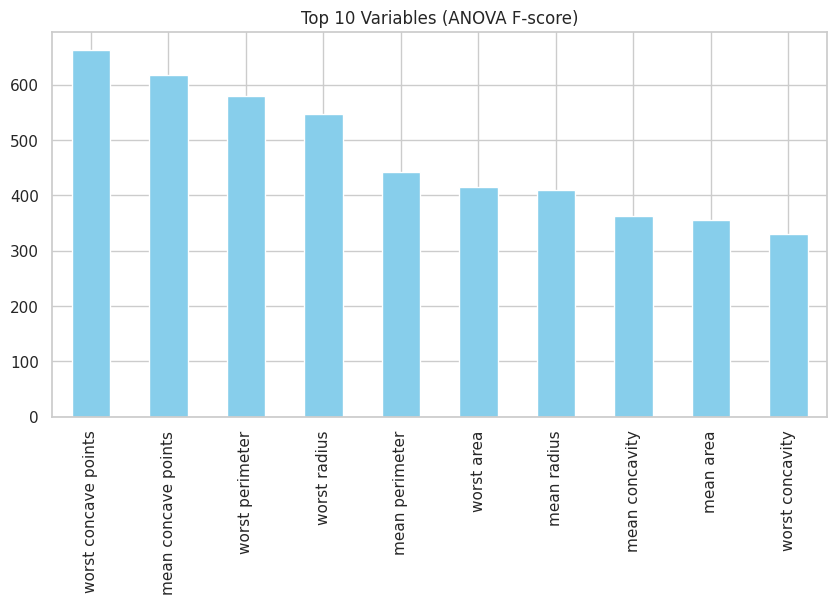

In [ ]:
# 1. Filtro por Varianza (Umbral de 0.01)
selector_var = VarianceThreshold(threshold=0.01)
X_train_var = selector_var.fit_transform(X_train)

# 2. Filtro Estadístico (ANOVA) - Seleccionamos las 10 mejores
selector_kbest = SelectKBest(score_func=f_classif, k=10)
X_train_kbest = selector_kbest.fit_transform(X_train, y_train)

print(f"Variables tras Varianza: {X_train_var.shape[1]}")
print(f"Variables tras ANOVA: {X_train_kbest.shape[1]}")

# Visualización de importancia estadística
scores = pd.Series(selector_kbest.scores_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
scores.head(10).plot(kind='bar', color='skyblue')
plt.title("Top 10 Variables (ANOVA F-score)")
plt.show()

## 2. Métodos Wrapper (Recursive Feature Elimination - RFE)
El método **Wrapper** envuelve un modelo y lo usa para decidir qué variables quitar.

**Algoritmo RFE:**
1. Entrena el modelo (ej. Random Forest).
2. Clasifica las variables por importancia.
3. Elimina la menos importante.
4. Repite hasta llegar al número deseado.

*Nota: Es muy preciso pero computacionalmente costoso.*

In [ ]:
# Usamos un estimador basado en árboles
rf = RandomForestClassifier(n_estimators=50, random_state=42)

# RFE para seleccionar 10 variables
selector_rfe = RFE(estimator=rf, n_features_to_select=10, step=1)
X_train_rfe = selector_rfe.fit_transform(X_train, y_train)

selected_rfe = X.columns[selector_rfe.support_]
print("Seleccionadas por RFE:", selected_rfe.tolist())

Seleccionadas por RFE: ['mean area', 'mean concavity', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']


## 3. Métodos Integrados (SelectFromModel + Lasso)
La selección ocurre **dentro** del algoritmo durante su entrenamiento. La **Regresión Lasso (L1)** es el ejemplo matemático más elegante.

**Matemática de la Penalización L1:**
Añade un término al error: $\lambda \sum |\beta_j|$.
Esto empuja los coeficientes de las variables irrelevantes a ser exactamente **0**.

In [ ]:
# Escalado necesario para modelos lineales como Lasso
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Lasso (Logit con penalización L1)
lasso = LogisticRegression(penalty="l1", solver="liblinear", C=0.2, random_state=42)
embedded_selector = SelectFromModel(lasso)
X_train_embedded = embedded_selector.fit_transform(X_train_scaled, y_train)

print(f"Variables que sobrevivieron a Lasso: {X_train_embedded.shape[1]}")

Variables que sobrevivieron a Lasso: 9


In [ ]:
selected_lasso_features = X.columns[embedded_selector.get_support()]
print("Variables seleccionadas por Lasso:", selected_lasso_features.tolist())

Variables seleccionadas por Lasso: ['mean concave points', 'radius error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst smoothness', 'worst concavity', 'worst concave points', 'worst symmetry']


## 4. Manejo de Variables Categóricas:
 Antes de seleccionar, debemos transformar.

**Pipeline sugerido:**
1.  **Imputación:** Llenar nulos.
2.  **Encoding:** OneHotEncoder (crea columnas 0/1), o el metodo que mejor se ajuste a tus datos.
3.  **Feature Selection:** Ahora sí aplicamos los filtros o modelos.

*Ejemplo rápido con datos ficticios:*

In [ ]:
df_cat = pd.DataFrame({'Ciudad': ['Madrid', 'BCN', 'Madrid', 'Sevilla'], 'Ventas': [10, 12, 11, 8]})
encoder = OneHotEncoder(sparse_output=False)
encoded_cats = encoder.fit_transform(df_cat[['Ciudad']])
df_encoded = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out())

print("Dataset transformado para selección:")
print(df_encoded)

Dataset transformado para selección:
   Ciudad_BCN  Ciudad_Madrid  Ciudad_Sevilla
0         0.0            1.0             0.0
1         1.0            0.0             0.0
2         0.0            1.0             0.0
3         0.0            0.0             1.0


## 5. Comparación Final de Modelos
Evaluamos si reducir variables mantuvo o mejoró la precisión del modelo original.

In [ ]:
def evaluar(X_tr, X_te, y_tr, y_te, nombre):
    clf = RandomForestClassifier(random_state=42).fit(X_tr, y_tr)
    acc = accuracy_score(y_te, clf.predict(X_te))
    print(f"{nombre}: {acc:.4f}")

# Evaluación (Nota: aplicamos la misma transformación al test)
evaluar(X_train, X_test, y_train, y_test, "Original (30 vars)")
evaluar(X_train_kbest, selector_kbest.transform(X_test), y_train, y_test, "SelectKBest (10 vars)")
evaluar(X_train_rfe, selector_rfe.transform(X_test), y_train, y_test, "RFE (10 vars)")

Original (30 vars): 0.9708
SelectKBest (10 vars): 0.9474
RFE (10 vars): 0.9649


---
## Bibliografía de Referencia
* **Guyon, I. & Elisseeff, A. (2003).** *An Introduction to Variable and Feature Selection*. Journal of Machine Learning Research.
* **Hastie, T., et al. (2009).** *The Elements of Statistical Learning*. Springer.
* **Pedregosa, F., et al. (2011).** *Scikit-learn: Machine Learning in Python*. JMLR.